# **Import the needed libraries and dependencies...**

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# **Load the dataset and perform EDA**

In [2]:
df=pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [4]:
df.info()
# as we can see there are three object data-type, so we need to convert them into numerical values by encoding

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
df.shape

(6362620, 11)

In [7]:
df.isnull().sum()
# no missing values as seen

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


# **We'll begin by converting the categorical columns into numerical ones for the ease of further processing**

In [8]:
# gonna start with manually encoding 'type' column as it only have 5 classes
type_map = {
    'CASH-IN':0 ,
    'CASH-OUT':1,
    'DEBIT':2,
    'PAYMENT':3,
    'TRANSFER':4
}
df['type'] = df['type'].map(type_map)


In [9]:
#as nameOrig and nameDest columns contain IDs which can be unique we first need to analyze if any of the IDs are being repeated for committing fraud before finalizing their encoding

# filter only fraud transactions
fraud_df = df[df['isFraud'] == 1]

# count frequency of nameOrig in frauds & display top 10 recurring acc
orig_fraud_counts = fraud_df['nameOrig'].value_counts()
print(orig_fraud_counts.head(10))
# ....|same for nameDest|....
dest_fraud_counts = fraud_df['nameDest'].value_counts()
print(dest_fraud_counts.head(10))

nameOrig
C1280323807    1
C1305486145    1
C840083671     1
C1420196421    1
C2101527076    1
C1039979813    1
C2089752665    1
C1614818636    1
C40604503      1
C1970706589    1
Name: count, dtype: int64
nameDest
C1981613973    2
C410033330     2
C1366192319    2
C1655359478    2
C803116137     2
C52390890      2
C1325541393    2
C904300960     2
C2020337583    2
C475338087     2
Name: count, dtype: int64


In [10]:
# as these columns shows no strong support for IDs being used repeatedly we won't go for labelled encoding and rather will use frequency encoding as this will give us an edge over monitoring accs frequently used(if really) for committing frauds
df['nameDest_freq'] = df['nameDest'].map(df['nameDest'].value_counts())
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)


In [11]:
# check if the encoding was successful, here, it is!
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            float64
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
 8   isFlaggedFraud  int64  
 9   nameDest_freq   int64  
dtypes: float64(6), int64(4)
memory usage: 485.4 MB


# **Perform feature scaling and train test split**

In [12]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# impute missing values in X with the mode
imputer_X = SimpleImputer(strategy='most_frequent')
X_imputed = imputer_X.fit_transform(X)



scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# train the Logistic Regression model
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train, y_train)

# evaluate the model
y_pred = lr.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_val, y_pred)}")

[[1228088   42793]
 [    104    1539]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98   1270881
           1       0.03      0.94      0.07      1643

    accuracy                           0.97   1272524
   macro avg       0.52      0.95      0.52   1272524
weighted avg       1.00      0.97      0.98   1272524

ROC AUC Score: 0.9515146195331061


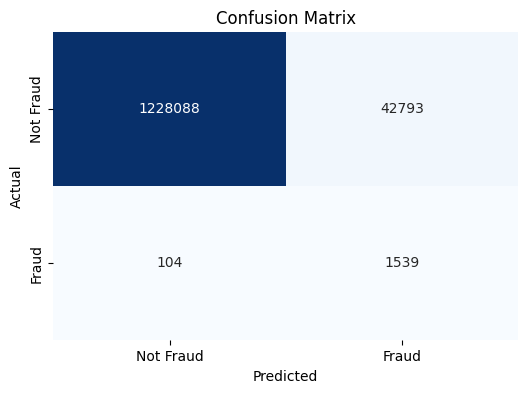

In [15]:
cm=confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# **Train an XGBoost classifier on the preprocessed data**



In [16]:
import xgboost as xgb

# Initialize and train the XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [17]:
# evaluate the trained xgboost
y_pred_xgb = xgb_model.predict(X_val)
print("Confusion Matrix (XGBoost):")
print(confusion_matrix(y_val, y_pred_xgb))
print("\nClassification Report (XGBoost):")
print(classification_report(y_val, y_pred_xgb))

y_probs_xgb = xgb_model.predict_proba(X_val)[:, 1]
print(f"\nROC AUC Score (XGBoost): {roc_auc_score(y_val, y_probs_xgb)}")

Confusion Matrix (XGBoost):
[[1270788      93]
 [    279    1364]]

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.94      0.83      0.88      1643

    accuracy                           1.00   1272524
   macro avg       0.97      0.92      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524


ROC AUC Score (XGBoost): 0.994559655041834


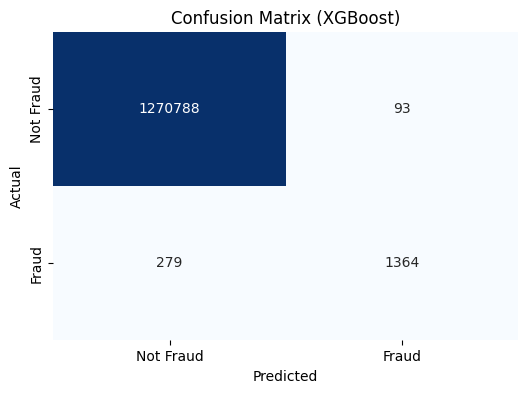

In [18]:
# visulaze w the help of cm
cm_xgb = confusion_matrix(y_val, y_pred_xgb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost)')
plt.show()

## **Comparing model performance**




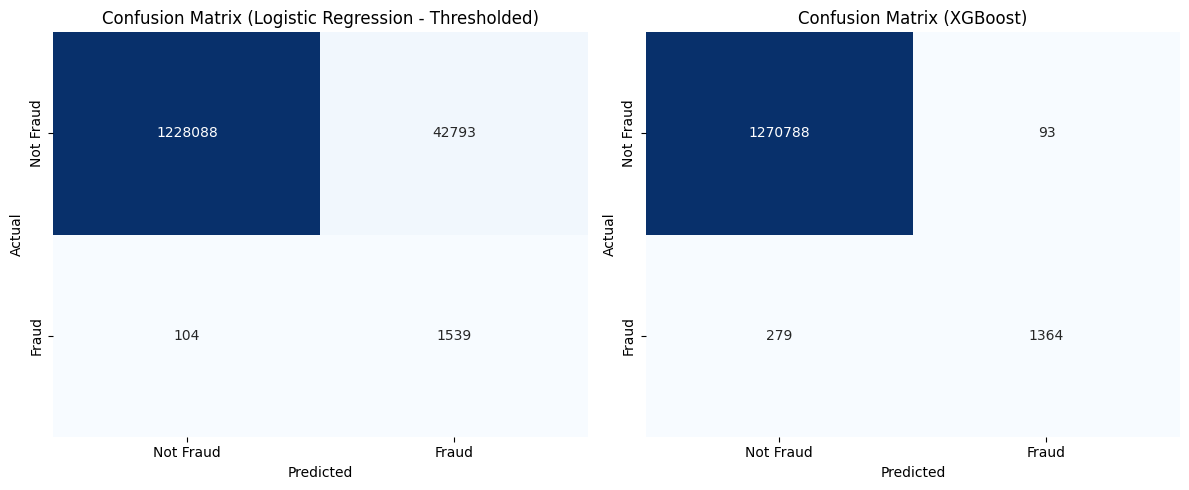

In [19]:
cm_lr = confusion_matrix(y_val, y_pred)

# confusion Matrix for XGBoost
y_pred_xgb = xgb_model.predict(X_val)
cm_xgb = confusion_matrix(y_val, y_pred_xgb)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# heatmap for Logistic Regression
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (Logistic Regression - Thresholded)')

# heatmap for XGBoost
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (XGBoost)')

plt.tight_layout()
plt.show()

# **Comparing important features and retraining the model**

/tmp/ipython-input-20-1206396997.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance_series.values, y=sorted_importance_series.index, ax=axes[0], palette='viridis')
/tmp/ipython-input-20-1206396997.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_coefficients.values, y=sorted_coefficients.index, ax=axes[1], palette='viridis')


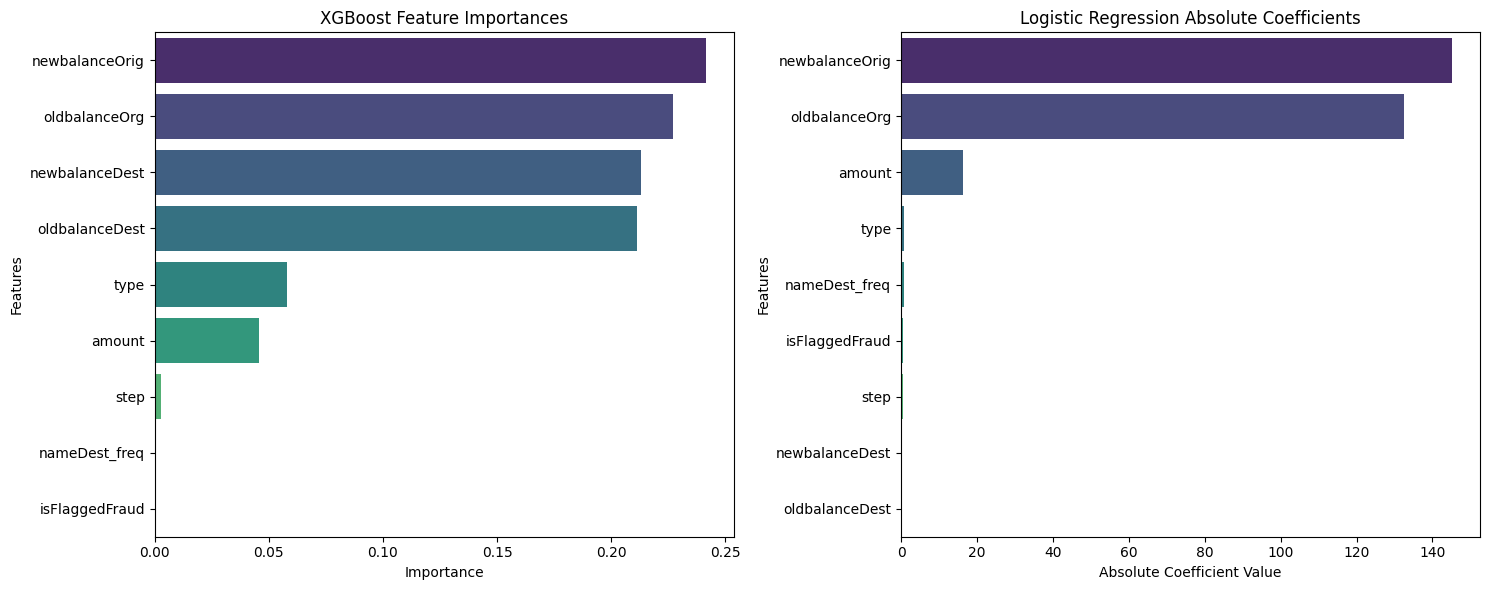

In [20]:
#feature importances from XGBoost
feature_importances = xgb_model.feature_importances_
feature_names = X.columns
importance_series = pd.Series(feature_importances, index=feature_names)
sorted_importance_series = importance_series.sort_values(ascending=False)

# absolute coefficients from Logistic Regression
lr_coefficients = lr.coef_[0]
coefficients_series = pd.Series(lr_coefficients, index=feature_names)
sorted_coefficients = coefficients_series.abs().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# feature importances for XGBoost
sns.barplot(x=sorted_importance_series.values, y=sorted_importance_series.index, ax=axes[0], palette='viridis')
axes[0].set_xlabel('Importance')
axes[0].set_ylabel('Features')
axes[0].set_title('XGBoost Feature Importances')

# absolute coefficients for LogReg
sns.barplot(x=sorted_coefficients.values, y=sorted_coefficients.index, ax=axes[1], palette='viridis')
axes[1].set_xlabel('Absolute Coefficient Value')
axes[1].set_ylabel('Features')
axes[1].set_title('Logistic Regression Absolute Coefficients')

plt.tight_layout()
plt.show()


# we see newbalanceOrig, oldbalanceOrg & amount are the most crucial features contributing to fraudulent commits and step, nameDest_freq, isFlaggedFraud are the less crucial factors so accordingly I'll update the model and check the score

In [40]:
print("XGBoost Feature Importances:")
print(sorted_importance_series)
print("\nLogistic Regression Absolute Coefficients:")
print(sorted_coefficients)

# Based on the plots and the printed series, newbalanceOrig, oldbalanceOrg, newbalanceDest, oldbalanceDest, and type appear to be consistently important across both models.
# I will select these top 6 features for retraining.
selected_features = ['newbalanceOrig', 'oldbalanceOrg', 'amount', 'type', 'oldbalanceDest', 'newbalanceDest']
print(f"\nSelected features for retraining: {selected_features}")

XGBoost Feature Importances:
newbalanceOrig    0.241576
oldbalanceOrg     0.227242
newbalanceDest    0.213198
oldbalanceDest    0.211178
type              0.057788
amount            0.045756
step              0.002914
nameDest_freq     0.000348
isFlaggedFraud    0.000000
dtype: float32

Logistic Regression Absolute Coefficients:
newbalanceOrig    145.258743
oldbalanceOrg     132.503958
amount             16.439164
type                0.887646
nameDest_freq       0.843641
isFlaggedFraud      0.614027
step                0.607579
newbalanceDest      0.227908
oldbalanceDest      0.055094
dtype: float64

Selected features for retraining: ['newbalanceOrig', 'oldbalanceOrg', 'amount', 'type', 'oldbalanceDest', 'newbalanceDest']


In [41]:
# Create a new DataFrame with only the selected features
X_selected = X[selected_features]

# Split the data into new training and validation sets using the full target variable y
X_train_selected, X_val_selected, y_train_selected, y_val_selected = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of new training set (features):", X_train_selected.shape)
print("Shape of new validation set (features):", X_val_selected.shape)
print("Shape of new training set (target):", y_train_selected.shape)
print("Shape of new validation set (target):", y_val_selected.shape)

Shape of new training set (features): (5090096, 6)
Shape of new validation set (features): (1272524, 6)
Shape of new training set (target): (5090096,)
Shape of new validation set (target): (1272524,)


Initialize and train a new XGBoost Classifier model using the training data with selected features.



In [42]:
# Initialize a new XGBoost Classifier model with random_state=42
xgb_model_selected = xgb.XGBClassifier(random_state=42)

# Fit the new XGBoost model to the training data with selected features
xgb_model_selected.fit(X_train_selected, y_train_selected)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Visualize the confusion matrix of the retrained XGBoost model trained on selected features and compare it with the original XGBoost model's confusion matrix.



# **Fine tune the retrained XGBoost model using hyperparameter tuning.**

In [43]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [44]:
# Initiate RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model_selected,
    param_distributions=param_grid,
    n_iter=5,
    cv=2,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1  # uses all available cores
)

# fit the RandomizedSearchCV object to the training data with selected features
random_search.fit(X_train_selected, y_train_selected)

# print the best hyperparameters found by the search
print("Best hyperparameters found by RandomizedSearchCV:")
print(random_search.best_params_)

Best hyperparameters found by RandomizedSearchCV:
{'subsample': 1.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [45]:
# get the best hyperparameters from the random search
best_params = random_search.best_params_

# initialize the final XGBoost model with the best hyperparameters
final_xgb_model = xgb.XGBClassifier(**best_params, random_state=42)

# train the final model on the full training data with selected features
final_xgb_model.fit(X_train_selected, y_train_selected)

# evaluate the final model on the validation data with selected features
y_pred_final = final_xgb_model.predict(X_val_selected)
print("Confusion Matrix (Fine-tuned XGBoost with selected features):")
print(confusion_matrix(y_val_selected, y_pred_final))
print("\nClassification Report (Fine-tuned XGBoost with selected features):")
print(classification_report(y_val_selected, y_pred_final))

y_probs_final = final_xgb_model.predict_proba(X_val_selected)[:, 1]
print(f"\nROC AUC Score (Fine-tuned XGBoost with selected features): {roc_auc_score(y_val_selected, y_probs_final)}")

Confusion Matrix (Fine-tuned XGBoost with selected features):
[[1270837      44]
 [    403    1240]]

Classification Report (Fine-tuned XGBoost with selected features):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.97      0.75      0.85      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.88      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524


ROC AUC Score (Fine-tuned XGBoost with selected features): 0.9996428991988627


# **Examine the predicted probabilities for false negatives from the fine-tuned XGBoost model to understand why they were misclassified.**


## Adjust the classification threshold of the fine-tuned XGBoost model to reduce false negatives.


Descriptive statistics of predicted probabilities for False Negatives:
count    403.000000
mean       0.197755
std        0.118268
min        0.000001
25%        0.103260
50%        0.175056
75%        0.286080
max        0.499122
Name: Predicted_Prob_Fraud, dtype: float64


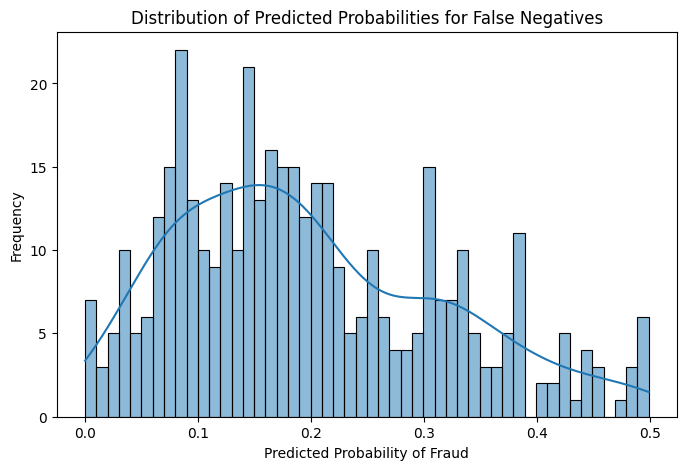

In [46]:
# get predicted probabilities for the positive class
y_probs_final = final_xgb_model.predict_proba(X_val_selected)[:, 1]

# create a DataFrame for analysis
results_df = pd.DataFrame({
    'True_Label': y_val_selected,
    'Predicted_Label': y_pred_final,
    'Predicted_Prob_Fraud': y_probs_final
})

# filter for false negatives
false_negatives_df = results_df[(results_df['True_Label'] == 1) & (results_df['Predicted_Label'] == 0)]

# analyze the distribution of predicted probabilities for false negatives
print("Descriptive statistics of predicted probabilities for False Negatives:")
print(false_negatives_df['Predicted_Prob_Fraud'].describe())

#visualize the distribution of predicted probabilities for false negatives
plt.figure(figsize=(8, 5))
sns.histplot(false_negatives_df['Predicted_Prob_Fraud'], bins=50, kde=True)
plt.title('Distribution of Predicted Probabilities for False Negatives')
plt.xlabel('Predicted Probability of Fraud')
plt.ylabel('Frequency')
plt.show()

Confusion Matrix (Fine-tuned XGBoost with selected features and threshold=0.45):
[[1270829      52]
 [    390    1253]]

Classification Report (Fine-tuned XGBoost with selected features and threshold=0.45):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.96      0.76      0.85      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.88      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524


ROC AUC Score (Fine-tuned XGBoost with selected features): 0.9996428991988627


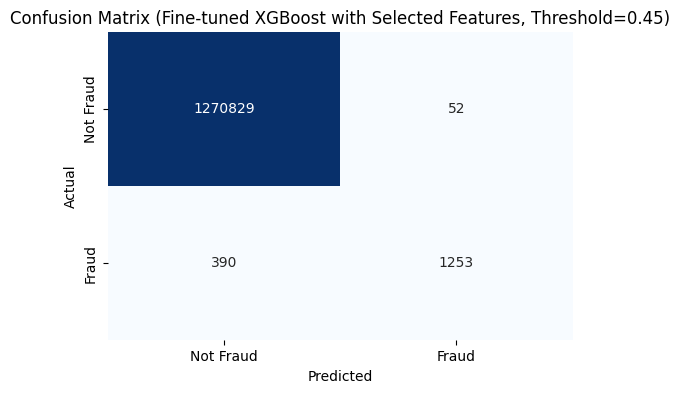

In [60]:
# Let's try a threshold of 0.45 as a starting point, based on the histogram.
threshold = 0.45 # this threshold can be shifted based on the cost to be considered with respect to customer's satisfaction and fraud transactions
y_pred_tuned = (y_probs_final >= threshold).astype(int)

# evaluate the model performance with the new threshold
print(f"Confusion Matrix (Fine-tuned XGBoost with selected features and threshold={threshold}):")
print(confusion_matrix(y_val_selected, y_pred_tuned))
print(f"\nClassification Report (Fine-tuned XGBoost with selected features and threshold={threshold}):")
print(classification_report(y_val_selected, y_pred_tuned))

# Calculate ROC AUC score with the new threshold (this is usually calculated on probabilities, but we can still check)
# Note: ROC AUC itself is threshold-independent, but evaluating performance metrics like precision/recall at a specific threshold is important.
print(f"\nROC AUC Score (Fine-tuned XGBoost with selected features): {roc_auc_score(y_val_selected, y_probs_final)}")
# Visualize the confusion matrix for the retrained xgboost model with the new threshold
cm_xgb_tuned = confusion_matrix(y_val_selected, y_pred_tuned)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb_tuned, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Fine-tuned XGBoost with Selected Features, Threshold={threshold})')
plt.show()